## Load labelled Tile
No NAN values in dataArray

In [17]:
import rioxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:

dataPath = '/Users/maaikeizeboud/Documents/Data/test/'
imName = 'test_labelled_tile.tif'

In [154]:
tile = rioxarray.open_rasterio(dataPath + imName)
tile.isnull().any()

<xarray.DataArray ()>
array(False)
Coordinates:
    spatial_ref  int64 0

In [26]:
# tile.shape
# tile = tile.transpose("x","y","band")

## Mask ocean from shapefile


In [76]:
import fiona
import rasterio

In [138]:
# coastline = 
shpPath = '/Users/maaikeizeboud/Documents/QGis/Quantarctica/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/'
shpfile = 'Coastline_Antarctica_v2.shp'

with fiona.open(shpPath+shpfile, "r") as src:
    src.meta
    shapes = [feature["geometry"] for feature in src]
    poly = [ft['coordinates'] for ft in shapes]
print(len(shapes),len(poly))

1 1


In [139]:
from geopandas import GeoSeries
from shapely import geometry

coast_geom = geometry.Polygon(np.squeeze(poly))
coast = GeoSeries(coast_geom,crs=tile.spatial_ref.crs_wkt) 


In [140]:
type(coast)

geopandas.geoseries.GeoSeries

### NB: add buffer to coastline

In [169]:

from rasterio.features import shapes, geometry_mask

mmask = geometry_mask(coast,out_shape=(len(tile.y),len(tile.x)),transform=tile.rio.transform(),invert=True)

# Inspect data type of mask -> ndarray
mmask = np.expand_dims(mmask,axis=0)
mmask.shape

numpy.ndarray

In [146]:
m2mask = mmask.astype(np.dtype('uint16'))
m2mask.shape

(1, 10002, 10004)

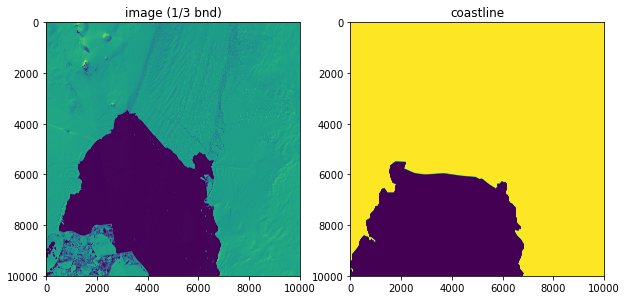

In [144]:
# imshow(amask[0])
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
s2 = ax2.imshow(m2mask[0])
ax1.imshow(tile[0,:,:]) 
ax2.set_title('coastline'); 
ax1.set_title('image (1/3 bnd)');
# fig.colorbar(s2,ax=ax2);

In [161]:
# import rasterio
# import rasterio.mask
# # out_image, out_transform = rasterio.mask.mask(tile, poly)#, crop=True)
# with rasterio.open(dataPath+imName) as src:
#     out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)

## Add mask to image as NaN ; windows with NaNs will be removed

In [173]:
masked_tile = tile;
print(masked_tile.shape, m2mask.shape)


masked_tile[0].shape
tmp = masked_tile[0]
a = m2mask == 0
print(tmp.shape,a.shape)

(4, 10002, 10004) (1, 10002, 10004)
(10002, 10004) (1, 10002, 10004)


## Make cut-outs with rolling window
### Problem: NaN values appear after  making cutouts 

In [5]:
# initialise rolling object
rolling = tile.rolling(
    x=20,
    y=20,
)
rolling

DataArrayRolling [x->20,y->20]

In [6]:

cutouts = rolling.construct(
    {'x':'x_win', 'y': 'y_win'}, 
    stride={'x': 15, 'y': 15}, # windwo_listing uses 'overlap' of 5, which is a stride of 15 for a window of 20pixels
)

In [22]:
cutouts.shape

<xarray.DataArray (band: 4, x_win: 20, y_win: 20, sample: 442225)>
array([[[[ 9072.,  9376.,  9408., ...,  9552.,  9592.,  9640.],
         [ 9160.,  9216.,  9288., ...,  9592.,  9616.,  9528.],
         [ 9352.,  9208.,  9056., ...,  9520.,  9656.,  9504.],
         ...,
         [ 9208.,  9056.,  9456., ...,  9656.,  9504.,  9304.],
         [ 9376.,  9312.,  9424., ...,  9616.,  9352.,  9504.],
         [ 9240.,  9280.,  9376., ...,  9608.,  9400.,  9520.]],

        [[ 9104.,  9488.,  9496., ...,  9768.,  9616.,  9616.],
         [ 9120.,  9376.,  9288., ...,  9680.,  9640.,  9432.],
         [ 9176.,  9144.,  8952., ...,  9504.,  9704.,  9408.],
         ...,
         [ 9144.,  8952.,  9424., ...,  9704.,  9408.,  9440.],
         [ 9304.,  9208.,  9384., ...,  9784.,  9432.,  9568.],
         [ 9344.,  9256.,  9280., ...,  9656.,  9504.,  9592.]],

        [[ 9168.,  9408.,  9504., ...,  9712.,  9608.,  9592.],
         [ 9144.,  9456.,  9456., ...,  9552.,  9592.,  9552.],
         [ 9208.,  9208.,  9104., ...,  9456.,  9552.,  9552.],
         ...,
...
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.]],

        [[    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         ...,
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.]],

        [[    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         ...,
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.],
         [    0.,     0.,     0., ...,     0.,     0.,     0.]]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4
    spatial_ref  int64 0
  * sample       (sample) MultiIndex
  - x            (sample) float64 -1.654e+06 -1.654e+06 ... -1.554e+06
  - y            (sample) float64 -2.67e+05 -2.671e+05 ... -3.664e+05 -3.666e+05
Dimensions without coordinates: x_win, y_win
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref
    long_name:     bands

In [8]:
cutouts.isnull().any()

<xarray.DataArray ()>
array(True)
Coordinates:
    spatial_ref  int64 0

#### Example of a cut-out window

In [9]:
# cutouts[0,0,0,:,:] 


#### issue: cutouts along the edge of the original raster are filled with NaN's


In [10]:
# create combined dimension from x and y ("sample")
cutouts = cutouts.stack(sample=["x", "y"])

In [11]:
cutouts.shape # bands, x_win, y_win, sample

(4, 20, 20, 444889)

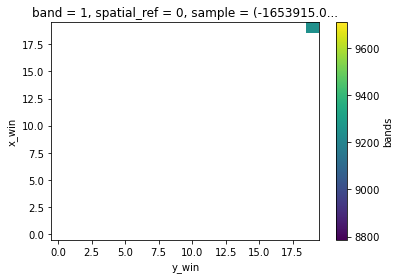

In [12]:
cutouts.attrs["long_name"] = "bands"
cutouts.isel(band=0, sample=0).plot.imshow()

In [13]:
# drop all NaN-containing cutouts - also useful if array has been masked with coastline shape
cutouts = cutouts.dropna(dim="sample", how="any")

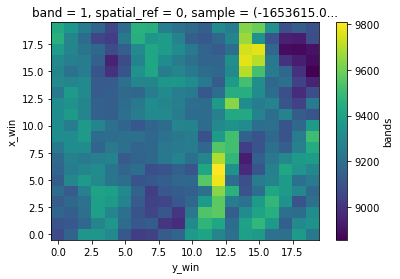

In [14]:
cutouts.isel(band=0, sample=0).plot.imshow()

In [15]:
cutouts.shape 

(4, 20, 20, 442225)